In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras.datasets import mnist
from keras.utils import np_utils
import sklearn
import sklearn.metrics

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

In [ ]:
#initialize the parameters randomly
def param_init(dim_layer):
    np.random.seed(1)
    params = {}
    length = len(dim_layer)            
    for i in range(1, length):
        params['W' + str(i)] = np.random.randn(dim_layer[i], dim_layer[i-1]) / np.sqrt(dim_layer[i-1]) #*0.01
        params['b' + str(i)] = np.zeros((dim_layer[i], 1))
    return params

In [ ]:
#sigmoid activation function
def sigmoid(z):
    a = 1/(1+np.exp(-z))
    prev = z
    return a, prev

In [ ]:
#rectified linear activation function
def relu(z):
    a = np.maximum(0,z)
    prev = z 
    return a, prev

In [ ]:
#essentially y=mx+c
def forward(a, W, b):
    z = W.dot(a) + b
    #store prev values because we will need it for backprop
    prev = (a, W, b)
    return z, prev

In [ ]:
#after y=mx+c, we need to pass it through activation fn. a = activation_function(y)
def forward_prop_activation(a_prev, W, b, act_fn):
    if act_fn == "sigmoid":
        z, prev_linear = forward(a_prev, W, b)
        a, prev_activation = sigmoid(z)
    elif act_fn == "relu":
        z, prev_linear = forward(a_prev, W, b)
        a, prev_activation = relu(z)
    #store the prev values because we will need it for backprop
    prev = (prev_linear, prev_activation)
    return a, prev

In [ ]:
#start feed forward. 1st to 2nd last layer is relu and last layer is sigmoid
def forward_prop(X, params):
    prevs = []
    a = X
    length = len(params) // 2 
    for i in range(1, length):
        a_prev = a 
        a, prev = forward_prop_activation(a_prev, params['W' + str(i)], params['b' + str(i)], act_fn = "relu")
        prevs.append(prev)
    yhat, prev = forward_prop_activation(a, params['W' + str(length)], params['b' + str(length)], act_fn = "sigmoid")
    prevs.append(prev)
    return yhat, prevs

In [ ]:
#calculate cross entropy loss or mean square loss
def error_calc(yhat, y):
    m = y.shape[1]
    error = (np.sum((y-yhat)**2))/m #mean square error
    #error = (1./m) * (-np.dot(y,np.log(yhat).T) - np.dot(1-y, np.log(1-yhat).T)) #cross entropy error
    error = np.squeeze(error)      # [[X]] into X).
    return error

In [ ]:
#backprop for sigmoid activation fn
def back_prop_sigmoid(da, prev):
    z = prev
    s = 1/(1+np.exp(-z))
    dz = da*s*(1-s)
    return dz

In [ ]:
#backprop for relu activation fn
def back_prop_relu(da, prev):
    z = prev
    dz = np.array(da, copy=True)
    dz[z<=0]=0
    return dz

In [ ]:
#backprop for the linear eq
def back(dz, prev):
    a_prev, W, b = prev
    m = a_prev.shape[1]
    dW = np.dot(dz,a_prev.T)/m
    db = np.sum(dz, axis = 1, keepdims = True)/m
    da_prev = np.dot(W.T,dz)
    return da_prev, dW, db

In [ ]:
#backpop for the activation fn and linear combined
def back_prop_activation(da, prev, act_fn):
    prev_linear, prev_activation = prev
    
    if act_fn == "relu":
        dz = back_prop_relu(da, prev_activation)
        da_prev, dW, db = back(dz, prev_linear)
        
    elif act_fn == "sigmoid":
        dz = back_prop_sigmoid(da, prev_activation)
        da_prev, dW, db = back(dz, prev_linear)
    
    return da_prev, dW, db

In [ ]:
#main backprop function
def back_prop(yhat, Y, prevs):
    gradients = {}
    length = len(prevs) 
    m = yhat.shape[1]
    Y = Y.reshape(yhat.shape)
    
    dyhat = - (np.divide(Y, yhat) - np.divide(1 - Y, 1 - yhat))
    
    latest_prev = prevs[length-1]
    gradients["da" + str(length-1)], gradients["dW" + str(length)], gradients["db" + str(length)] = back_prop_activation(dyhat, latest_prev, act_fn = "sigmoid")
    
    for i in reversed(range(length-1)):
        latest_prev = prevs[i]
        da_prev_temp, dW_temp, db_temp = back_prop_activation(gradients["da" + str(i + 1)], latest_prev, act_fn = "relu")
        gradients["da" + str(i)] = da_prev_temp
        gradients["dW" + str(i + 1)] = dW_temp
        gradients["db" + str(i + 1)] = db_temp

    return gradients

In [ ]:
#update weights using W = W - alpha*dW
def weight_update(params, gradients, alpha_lr):
    length = len(params) // 2 
    for i in range(length):
        params["W" + str(i+1)] = params["W" + str(i+1)] - alpha_lr * gradients["dW" + str(i+1)]
        params["b" + str(i+1)] = params["b" + str(i+1)] - alpha_lr * gradients["db" + str(i+1)]       
    return params

In [ ]:
def no_of_parameters(dim_layers):
    no_of_params = 0
    i=0
    for i in range(len(dim_layers)-1):
        no_of_params = no_of_params + dim_layers[i]*dim_layers[i+1]
    for i in range(len(dim_layers)):
        if i != 0:
          no_of_params += dim_layers[i]

    print("Number of parameters = ", no_of_params)

In [ ]:
def model_train(X, Y, dim_layers, alpha_lr = 0.0075, epochs = 3000):#lr was 0.009
    np.random.seed(1)
    errors = [] 
    accuracy = []
    params = param_init(dim_layers)
    for epoch_no in range(0, epochs):
        #feed forward
        yhat, caches = forward_prop(X, params)
        #error calc
        error = error_calc(yhat, Y)
        #backprop
        gradients = back_prop(yhat, Y, caches)
        #weight update
        params = weight_update(params, gradients, alpha_lr)
                
        #if epoch_no%100 == 0:
        print("Epoch number " + str(epoch_no) + ", Error: " + str(error))
        errors.append(error)
            
    plt.plot(np.squeeze(errors))
    plt.ylabel('error')
    plt.xlabel('epochs')
    plt.title('using mean square error')
    plt.show()

    no_of_parameters(dim_layers)

    return params

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


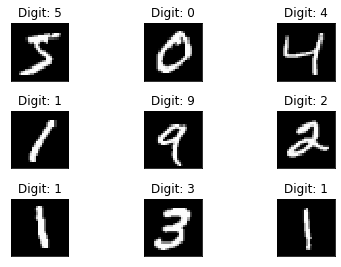

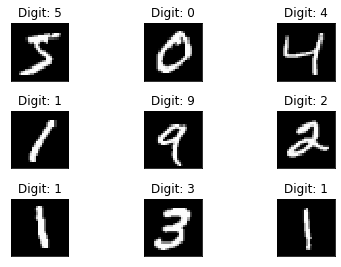

In [ ]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


In [ ]:
#Flatten the image to 1D
train_x_flatten = X_train.reshape(X_train.shape[0], -1).T 
test_x_flatten = X_test.reshape(X_test.shape[0], -1).T

# Standardize so feature values are b/w 0 and 1
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

train_x's shape: (784, 60000)
test_x's shape: (784, 10000)


In [ ]:
#One hot encoding
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [ ]:
train_y = Y_train.reshape([10,60000])
test_y = Y_test.reshape([10, 10000])

print("train_y shape", train_y.shape)
print("test_y shape", test_y.shape)

train_y shape (10, 60000)
test_y shape (10, 10000)


In [ ]:
#Since datatset is so large, we are only taking 6000 images for training and 1000 images for testing
train_x = train_x[:, :6000]
train_y = train_y[:, :6000]
test_x = test_x[:, :1000]
test_y = test_y[:, :1000]

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))
print("train_y shape", train_y.shape)
print("test_y shape", test_y.shape)

train_x's shape: (784, 6000)
test_x's shape: (784, 1000)
train_y shape (10, 6000)
test_y shape (10, 1000)


In [ ]:
#Enter hyperparameters here 
#Number of layers = number of elements
#Number of nodes in each layer = value of each element

#Shallow (4layer) and thin network
dim_layers = [784, 30, 15, 10]
alpha_lr = 0.0007
epochs = 2000

Epoch number 0, Error: 2.6357025153425058
Epoch number 1, Error: 2.63034442928514
Epoch number 2, Error: 2.625191526248478
Epoch number 3, Error: 2.6202462392789356
Epoch number 4, Error: 2.6155140369439827
Epoch number 5, Error: 2.6109803665471607
Epoch number 6, Error: 2.606616671846239
Epoch number 7, Error: 2.6024253208514345
Epoch number 8, Error: 2.5983999724031865
Epoch number 9, Error: 2.594524809230149
Epoch number 10, Error: 2.59078337043463
Epoch number 11, Error: 2.5871664612610443
Epoch number 12, Error: 2.5836605847472414
Epoch number 13, Error: 2.580265000788005
Epoch number 14, Error: 2.5769786148683775
Epoch number 15, Error: 2.573795138958469
Epoch number 16, Error: 2.5707124205772818
Epoch number 17, Error: 2.5677229317166015
Epoch number 18, Error: 2.5648198711390777
Epoch number 19, Error: 2.5619955379723094
Epoch number 20, Error: 2.55923975642209
Epoch number 21, Error: 2.5565572263590273
Epoch number 22, Error: 2.5539427485855026
Epoch number 23, Error: 2.551396

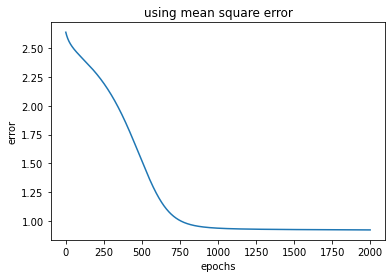

Number of parameters =  24175
CPU times: user 4min 3s, sys: 42.1 s, total: 4min 45s
Wall time: 2min 29s


In [ ]:
%%time
params = model_train(train_x, train_y, dim_layers, alpha_lr, epochs)

In [ ]:
#Enter hyperparameters here 
#Number of layers = number of elements
#Number of nodes in each layer = value of each element
#Shallow (4layer) and wide network
dim_layers = [784, 512, 512, 10]
alpha_lr = 0.0007
epochs = 2000

Epoch number 0, Error: 2.6152756740805048
Epoch number 1, Error: 2.6022453258254994
Epoch number 2, Error: 2.5893433933443375
Epoch number 3, Error: 2.576564817974937
Epoch number 4, Error: 2.563906526357361
Epoch number 5, Error: 2.5513667368573794
Epoch number 6, Error: 2.5389402757453907
Epoch number 7, Error: 2.526627060975864
Epoch number 8, Error: 2.5144213211823185
Epoch number 9, Error: 2.5023193272363273
Epoch number 10, Error: 2.4903190074439108
Epoch number 11, Error: 2.4784186852659253
Epoch number 12, Error: 2.4666148362670848
Epoch number 13, Error: 2.4549038053050496
Epoch number 14, Error: 2.4432813731445293
Epoch number 15, Error: 2.431746690946586
Epoch number 16, Error: 2.420297758810647
Epoch number 17, Error: 2.4089316590651113
Epoch number 18, Error: 2.3976485044277527
Epoch number 19, Error: 2.3864458218287035
Epoch number 20, Error: 2.3753202627395096
Epoch number 21, Error: 2.3642705268005306
Epoch number 22, Error: 2.3532951130219746
Epoch number 23, Error: 2.

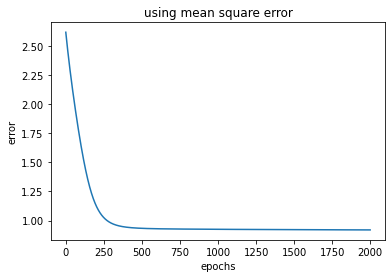

Number of parameters =  669706
CPU times: user 50min 7s, sys: 5min 13s, total: 55min 20s
Wall time: 28min 26s


In [ ]:
%%time
params = model_train(train_x, train_y, dim_layers, alpha_lr, epochs)

In [ ]:
#Enter hyperparameters here 
#Number of layers = number of elements
#Number of nodes in each layer = value of each element
dim_layers = [784, 700, 650, 600, 550, 512, 450, 400, 350, 300, 250, 200, 150, 100, 50, 10]
alpha_lr = 0.0075
epochs = 2000

Epoch number 0, Error: 2.5005072508680986
Epoch number 1, Error: 2.4919612733842724
Epoch number 2, Error: 2.4838827919852227
Epoch number 3, Error: 2.475421125150096
Epoch number 4, Error: 2.466582880096494
Epoch number 5, Error: 2.4577160994827114
Epoch number 6, Error: 2.4487592928731603
Epoch number 7, Error: 2.4398039641868965
Epoch number 8, Error: 2.4309261671468216
Epoch number 9, Error: 2.4221099741475505
Epoch number 10, Error: 2.4133399394473467
Epoch number 11, Error: 2.40460042418776
Epoch number 12, Error: 2.395873592197877
Epoch number 13, Error: 2.387150720723974
Epoch number 14, Error: 2.3784444331976498
Epoch number 15, Error: 2.369762490222611
Epoch number 16, Error: 2.361105475019998
Epoch number 17, Error: 2.352474137938002
Epoch number 18, Error: 2.343868116755826
Epoch number 19, Error: 2.335287659663354
Epoch number 20, Error: 2.326731565659064
Epoch number 21, Error: 2.3181968188289064
Epoch number 22, Error: 2.3096797894781744
Epoch number 23, Error: 2.3011755

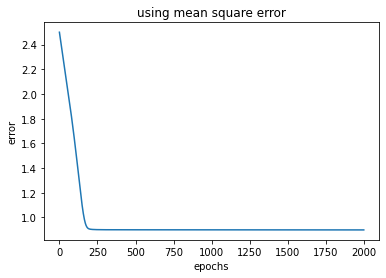

Number of parameters =  2841572
CPU times: user 3h 37min 22s, sys: 22min 57s, total: 4h 19s
Wall time: 2h 2min 52s


In [ ]:
%%time
params = model_train(train_x, train_y, dim_layers, alpha_lr, epochs)